In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# **In-depth tutorial: single cycle**

This tutorial/example aims to go a bit more **in-depth** into the **code-base** compared to the "Hello World" example, and discuss the **major classes** and **functions**, and how they relate to one another. 

The outcome is the **implementation** of a **single update loop**.

## **I - Cosmic muon generation**
The `tomopt.muon` contains functions and classes to deal with the generation and handling of muons.

`tomopt.muon.generation.MuonGenerator2016` will generate N muons on demand via random sampling. These are stored as an (N,5) tensor, with columns corresponding to (x,y,momentum,$\theta_x$,$\theta_y$), where $\theta$ is the angle between the z-axis and the trajectory of the muon in x & y. 

Currently x & y are uniform in the specified ranges, momentum and the $\theta$ are sampled from cosmic muon distribution at sea level [(arXiv:1606.06907)](https://arxiv.org/abs/1606.06907). Additionally, the momenta can be fixed to a specified value. Currently a value of 5GeV is recommended.

The user is also free to implement its own parametrization of the cosmic muon flux through a horizontal surface as:

$$
\Phi_z\left( E, \theta \right) = \frac{dN}{dE \cdot dS_n \cdot d\Omega} \cdot sin\theta \cdot cos\theta \:\:\:\: \text{m}^{-2}.\text{sr}^{-1}.\text{GeV}^{-1}
$$

by creating a MuonGenerator class inheriting from `AbsMuonGenerator` with the dedicated `flux` method.

More details about the cosmic muon generation can be found in Section 2.1 *Detector modelling and hit recording* of the [TomOpt paper](https://iopscience.iop.org/article/10.1088/2632-2153/ad52e7).

In [2]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [3]:
gen = MuonGenerator(x_range=(0.0,1.0), y_range=(0.0,1.0), fixed_mom=5)
gen

Muon generator: x,y range: (0.0, 1.0), (0.0, 1.0). Momentum is fixed at 5 GeV

Muons can be generated by calling the `MuonGenerator.generate_set` function, for convenience this is linked to the class' `__call__` method:

In [4]:
gen.generate_set(10), gen(10)

(tensor([[0.2159, 0.8368, 5.0000, 1.0171, 5.5738],
         [0.3352, 0.0163, 5.0000, 0.7666, 1.2542],
         [0.8749, 0.6603, 5.0000, 0.8033, 6.0561],
         [0.5328, 0.0632, 5.0000, 0.1985, 0.2645],
         [0.3525, 0.3752, 5.0000, 0.7972, 1.5690],
         [0.8175, 0.4404, 5.0000, 0.8155, 4.8659],
         [0.6075, 0.5777, 5.0000, 0.4979, 4.1212],
         [0.5885, 0.7920, 5.0000, 0.2963, 6.0555],
         [0.0166, 0.2481, 5.0000, 0.4368, 2.0091],
         [0.0755, 0.0237, 5.0000, 0.6078, 1.9398]]),
 tensor([[0.6594, 0.9083, 5.0000, 0.9927, 2.9201],
         [0.9177, 0.0393, 5.0000, 0.4123, 2.5114],
         [0.6507, 0.7305, 5.0000, 0.9621, 5.2211],
         [0.4719, 0.1397, 5.0000, 0.3757, 5.1897],
         [0.7297, 0.4183, 5.0000, 0.3512, 1.8158],
         [0.8062, 0.5786, 5.0000, 0.1924, 4.2929],
         [0.9930, 0.2276, 5.0000, 0.2841, 1.7756],
         [0.8511, 0.0066, 5.0000, 0.6567, 4.4170],
         [0.3069, 0.5815, 5.0000, 0.5956, 5.1483],
         [0.6703, 0.7038, 5.0

To provide a more convenient interface, `tomopt.muon.muon_batch.MuonBatch` is used to wrap the generated muons with methods, and property getters and setters. 


When instantiating a `MuonBatch`, we also need to tell it where the muons start in z.

In [5]:
from tomopt.muon import MuonBatch

In [6]:
muons = MuonBatch(gen(10000), init_z=1)
muons

Batch of 10000 muons

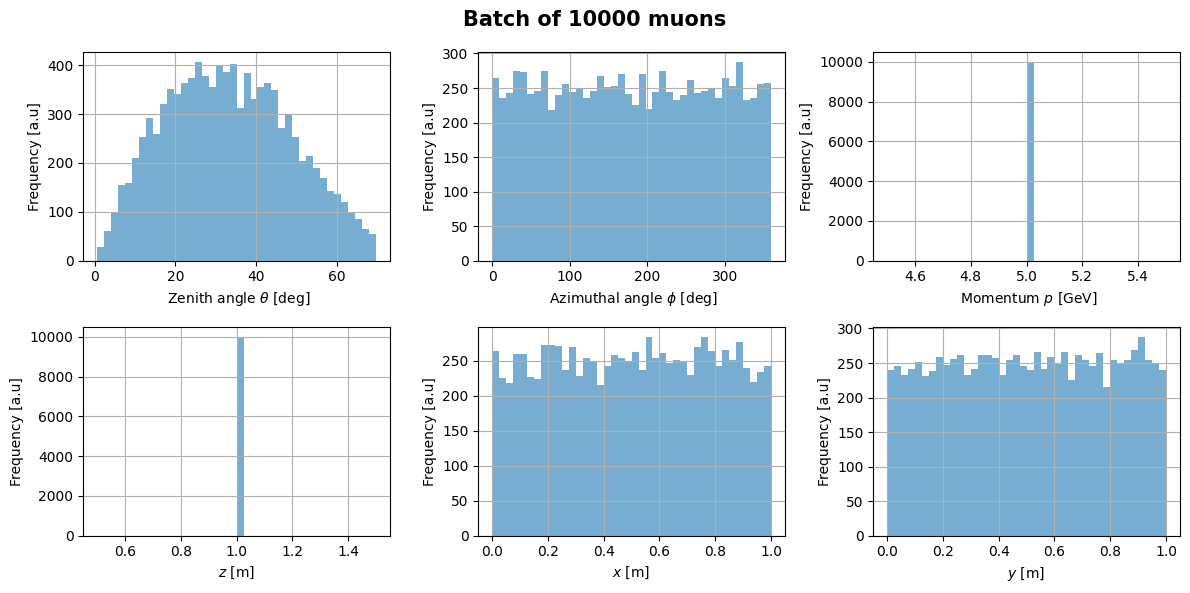

In [7]:
import sys
sys.path.insert(1, '../')

from plotting.plotting import plot_muon_batch
plot_muon_batch(muons)

Propagation of the muons proceeds in steps of $\delta z$ in the negative z direction.

In [8]:
muons.propagate_dz(dz=0.1)

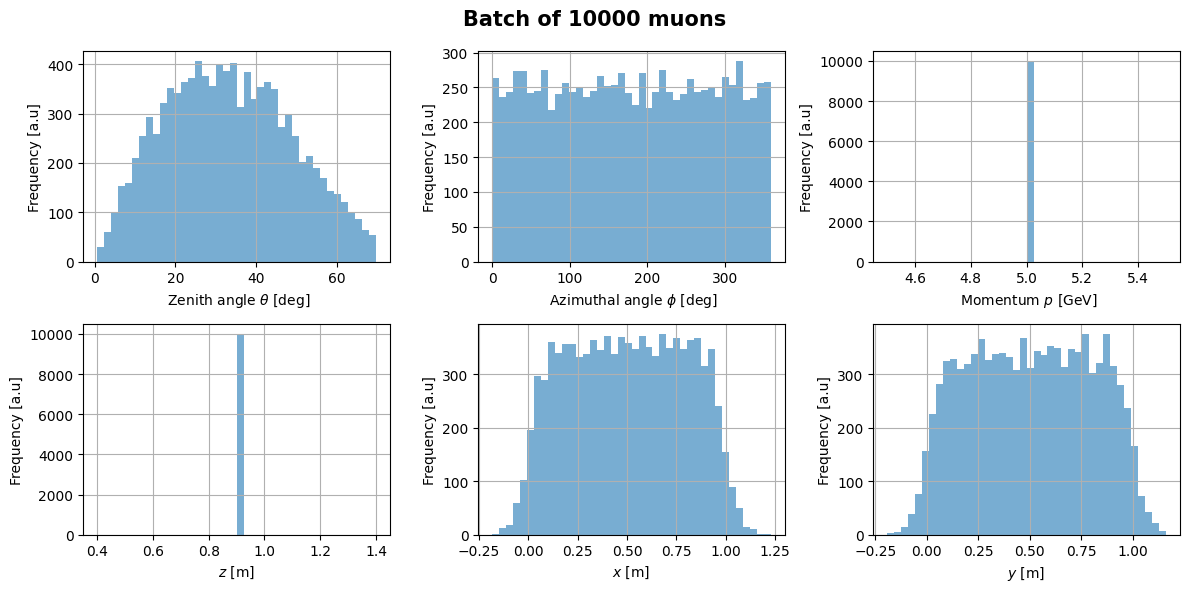

In [9]:
plot_muon_batch(muons)

Normally, though, we let the **volume layers** (see section **III**) **call** the `propagate` method. 

## **II - Volume definition**

### **A - Passive volume definition**
First let's set up the **volume**; a block occupying (x,y,z) space from (0,0,0)->(L,W,H).

The `tomopt.volume` contains **methods** and **classes** to enable the **definition** of the **active** and **passive volumes**, the latter of which are subdivided into cubic voxels of width *size*.

Each **voxel** can be specified as a different **material** with varying $X_0$ (radiation length [m]). `tomopt.core.X0` includes a dictionary of the x0 in various materials.

**Construction** of a **passive volume** is done **layer-wise** in the $z$-axis, and each layer should be a `tomopt.volume.layer.PassiveLayer`. These are initialised by stating:

 - `z`: the z-position of the **top** of the layer
 - `lw`: the transverse **length** and **width** of layer
 - `size`: the **size** of each voxel (simultaneously defines the depth of the layer and the number of voxels in the layer). The user should ensure that the **length** and **width** are both **divisible** by the **size**. 
 
 The materials of the voxels in the layer are defined using a function which takes the coordinates of the layer and returns an (N,M) tensor with the X0 of material for the (NxM voxels in x,y).

*Current limitations*:
- The **scattering model** used is highly **simplified**.
- The computation of the number of radition lengths in a $\delta z$ step is based solely on the material of the voxel at the start of the step.

Below, we'll look at how to construct a passive layer

In [10]:
import torch
from torch import Tensor
from tomopt.core import X0

The function below takes the layer coordinates and returns a tensor with voxel material for the layer at the specified z, In this case, it will return beryllium for all voxels, except for the layer at z=0.4, which will contain a block of lead for x_voxels > 5 and y_voxels > 5. 

Note that the function takes absolute coordinates in metres and must manually convert to voxel-coordinates using the size.

In [11]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['iron']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [12]:
from tomopt.volume import PassiveLayer
pl = PassiveLayer(rad_length_func=arb_rad_length, lw=Tensor([1,1]), z=0.2, size=0.1)

### **B - Hodoscope module definition**

The default TomOpt's implementaion is designed for the optimisation of independent detection panels. Each of them have a set of **free parameters**: **position** and **span**.

This branch of TomOtp is designed to optimize the layout of detection modules called **hodoscopes**, which themselves contain detection planes with **fixed span**. 

Each hodoscope then only has 3 free parameters to be optimised: its $x$, $y$ and $z$ position, and are responsible for the detection of the muons.

The **hodoscope** is parametrized as follow:

 - `init_xyz`: The initial position of the top (along $z$) center (along $xy$) of the hodoscope.
 - `init_span`: The initial span of the hodoscope in $xyz$.
 - `n_panels`: The number of detector panels to be placed within the hodoscope.
 - `xyz_gap`: The gap between the edges of the hodoscope and the detector panels along $xyz$.
 - `eff`: The individual panels efficiency
 - `res`: The inverse panels spatial resolution $\frac{1}{\sigma}$ in $m^{-1}$
 - `realistic_validation`: 

In [13]:
import sys
sys.path.insert(1, '../')
from volume.hodoscope import Hodoscope

hod = Hodoscope(
    init_xyz= [.5, .5, 1.], # Position x,y,z in meters
    init_xyz_span = [1.5 , 1.5, .4], # Detection panels span dx, dy, dz im meters
    xyz_gap = [.1, .1, .1], # Gap between panels and 
    eff = 0.9, # Muon detection per panel efficiency
    res = 1e4, # Detection panels 
    )

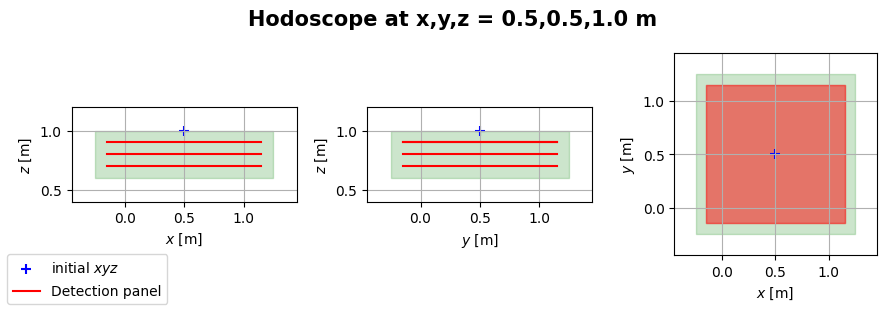

In [14]:
hod.draw()

### **C - Detector layer definition**

Detector layers form regions of space **above** and **below** the **passive volume** and contain a fixed number of **hodoscopes**, each of which spans a varying $xy$ area, is centred at a vaying $x,y,z$ coordinate, and has a fixed **resolution** and **efficiency**. 

The position of the detection modules is the parameter to be optimised. 

*Current limitations*:
- Detection modules are not implemented as a "physical" object and do **not** scatter muons.

The **hodoscope** is parametrized as follow:
 - `pos`: Used to indicate if the layer is above or below the passive volume.
 - `lw`: The transverse length and width of layer, in meters.
 - `z`: Position of the top of the layer in $z$.
 - `size`: The height in $z$, in meters.
 - `hodoscopes`: The hodoscopes instances as a `nn.ModuleList`. 

In [15]:
init_xyz_span, xyz_gap = [1.5, 1.5, 0.3], [0.1, 0.1, 0.1]
init_eff, init_res = 0.90, 1e3

hods = [
    Hodoscope(
        init_xyz = [0.5, 0.5, z],
        init_xyz_span = init_xyz_span,
        xyz_gap = xyz_gap,
        eff = init_eff,
        res = init_res,
        realistic_validation = False
    ) for z in [1.3, 1.]
]

from torch import Tensor
from volume.hodoscopelayer import HodoscopeDetectorLayer

# Above detector layer
layer_above = HodoscopeDetectorLayer(
        pos = "above", 
        lw = Tensor([2, 2]), 
        z = 1.3, 
        size = 0.5, 
        hodoscopes=hods
    )

The instances of `DetectorPanel` within each hodoscope is responsible for the detection of the muons.

When muons get propagated to the the $z$ position of a `DetectorPanel`, their `get_hits` method gets called and returns the hits in the panel of the muons.

- In training mode, **all** muons have valid hits, regardless of whether the muons lie within the panel or not. The reconstructed hits are perturbed by a distance in $xy$ according to the inverse of a resolution evaluated from a pair of Gaussians in $xy$ centred at the centre of the panel, with scales equal to a quarter of the $xy$-span of the panel (i.e. the span is the width of the panel, and equates to 2-sigma of the Gaussian mode).
    - In this way, all muons can be used for optimisation of the panel parameters, and the reco hits are differentiable w.r.t. the $xy$ position of the detector, and the $xy$-span.
    
- In evaluation mode, muons have reco. hits perturbed by the inverse of a resolution, which is equal to the resolution of the panel for hits falling within the panel, and 0 outside the panel. Thus muons outside the have their reco. hits located at $\pm\infty$, and have infinite uncertainty. The scattering infernce (described later) will thus ignore these hits.
- Regardless of mode, all muons falling within the panel have their reconstructed hits clamped to lie within the panel.

The mode of the panel also affects the efficiency of the panel:
- In **training mode**, the efficiency is computed from the product of the $xy$ Gaussians centred on the panel, evaluated at the true position of the muon (rather than the reconstructed hit)
- In **evaluation mode**, the efficiency is computed as the panel efficiency for muons within the panel, and 0 elsewhere.

More details about the muon hit recording can be found in Section 2.2 *Detector modelling and hit recording* of the [TomOpt paper](https://iopscience.iop.org/article/10.1088/2632-2153/ad52e7).

Let's generate a batch of 10k muons above the detector layer, at $z = 1.4$ m:

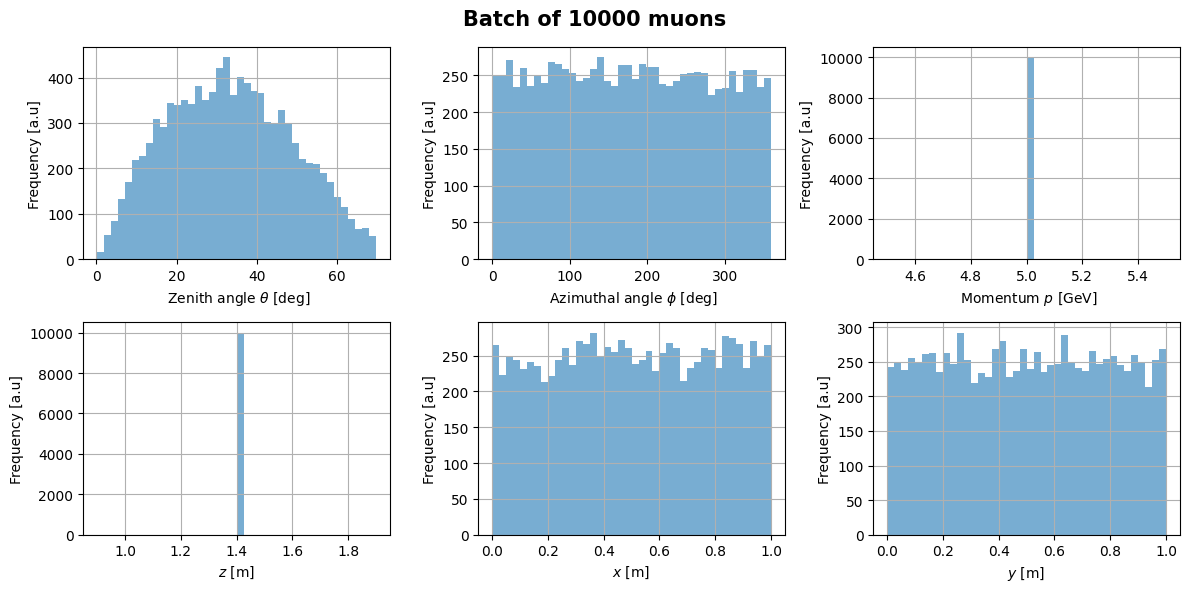

In [16]:
gen = MuonGenerator(x_range=(0.0,1.0), y_range=(0.0,1.0), fixed_mom=5)
muons = MuonBatch(gen(10000), init_z=1.4)
plot_muon_batch(muons)

We can **record** the hits of each muons through each panel of each hodoscope. Having 2 hodoscopes with 3 panels, we get 6 sets of hits:

In [17]:
# Get hits of each panel of each hodoscope
hits = [p.get_hits(muons) for h in layer_above.hodoscopes for p in h.panels]
len(hits), hits[0]

(6,
 {'reco_xyz': tensor([[0.0044, 0.5050, 1.2000],
          [0.9310, 0.5362, 1.2000],
          [0.2320, 0.4983, 1.2000],
          ...,
          [0.5081, 0.7330, 1.2000],
          [0.9546, 0.5818, 1.2000],
          [0.6643, 0.8942, 1.2000]], grad_fn=<CopySlices>),
  'gen_xyz': tensor([[9.1681e-04, 5.0605e-01, 1.2000e+00],
          [9.3373e-01, 5.3833e-01, 1.2000e+00],
          [2.2911e-01, 4.9786e-01, 1.2000e+00],
          ...,
          [5.0857e-01, 7.3234e-01, 1.2000e+00],
          [9.5178e-01, 5.8088e-01, 1.2000e+00],
          [6.6247e-01, 8.9431e-01, 1.2000e+00]], grad_fn=<CopySlices>),
  'unc_xyz': tensor([[0.0033, 0.0010, 0.0000],
          [0.0024, 0.0010, 0.0000],
          [0.0014, 0.0010, 0.0000],
          ...,
          [0.0010, 0.0013, 0.0000],
          [0.0026, 0.0010, 0.0000],
          [0.0011, 0.0021, 0.0000]], grad_fn=<ConstantPadNdBackward0>),
  'eff': tensor([[0.2768],
          [0.3668],
          [0.6359],
          ...,
          [0.6968],
          [

In [18]:
def plot_hits(hits: Tensor, ) -> None:

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(ncols = 3, figsize = (12, 4))
    fig.suptitle("Muon hits", fontsize = 15, fontweight = "bold")

    # Plot muon hits x position
    axs[0].hist(hits[:, 0], bins = 50)
    axs[0].set_xlabel(r"$x$ [m]")

    # Plot muon hits y position
    axs[1].hist(hits[:, 1], bins = 50)
    axs[1].set_xlabel(r"$y$ [m]")

    # Plot muon hits xy position 
    axs[2].scatter(hits[:, 0], hits[:, 1], alpha = .1)
    axs[2].set_xlabel(r"$x$ [m]")
    axs[2].set_ylabel(r"$y$ [m]")
    axs[2].set_aspect("equal")

    for ax in axs[:-1]:
        ax.grid("on")
        ax.set_ylabel("Frequency [a.u]")
    plt.tight_layout()
    plt.show()

The $xy$ coordinates are the positions of the muons as recorded by the detector, and is computed according to: 

$$
x_{\mathrm{reco}} = x_{\mathrm{true}} + \mathcal{N}\left(\mu = 0,\sigma = \mathrm{res}^{-1}\right)
$$, 

where $\mathcal{N}$ is normal distribution. The resolution may be computed differently according to whether the layer is being **trained** or **evaluated** (as discussed above).

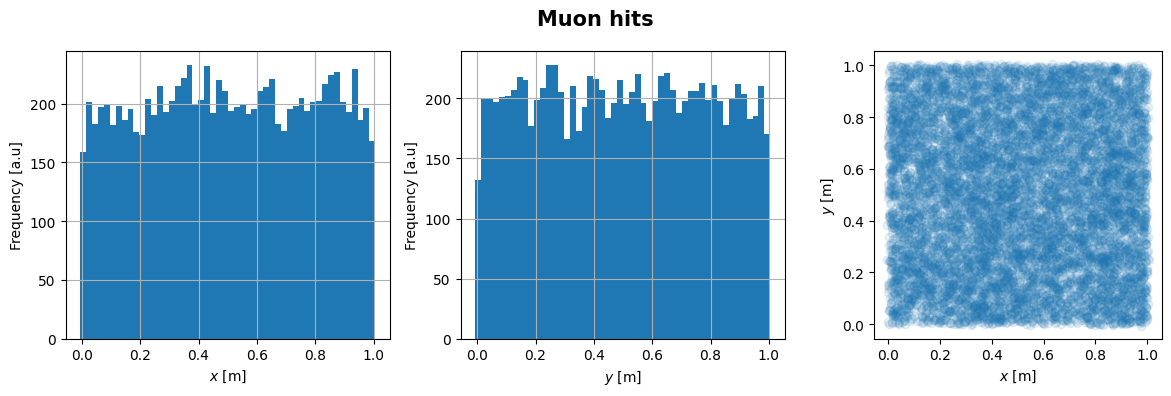

In [19]:
# Plot reconstructed hits
plot_hits(hits[0]["reco_xyz"].detach().numpy())


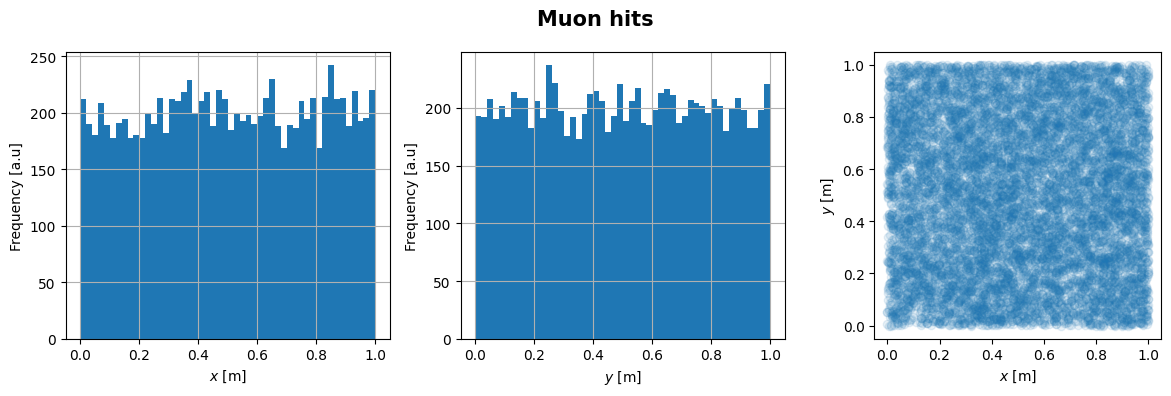

In [20]:
# Plot reconstructed hits
plot_hits(hits[0]["gen_xyz"].detach().numpy())


### **D - Building the whole volume**

Now we can build both passive and detector layers, we can build the full volume by stacking layers together in z, remembering that we need two pairs of detector layers. 

Let's create the detector layer below the passive volume:

In [21]:
hods = [
    Hodoscope(
        init_xyz = [0.5, 0.5, z],
        init_xyz_span = init_xyz_span,
        xyz_gap = xyz_gap,
        eff = init_eff,
        res = init_res,
    ) for z in [-0.1, -0.4]
]

# Below detector layer
layer_below = HodoscopeDetectorLayer(
        pos = "below", 
        lw = Tensor([2, 2]), 
        z = 0.0, 
        size = 0.5, 
        hodoscopes=hods
    )

Below we write a function to return a 1x1x1 m cube with 5 layers (size=0.1m), with the layers stored in a `torch.nn.ModuleList`.

The **hodoscopes** and **passives** **layers** are then sandwiched together:

In [22]:
import torch
from torch import nn
from tomopt.volume import PassiveLayer

DEVICE = torch.device('cpu')

def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1, 1, 1])
        size = 0.1
        # Above hodoscope layer
        layers.append(hod_layers[0])

        # Passive layers
        for z in [0.7, 0.6, 0.5, 0.4, 0.3]:
            layers.append(PassiveLayer(
                  rad_length_func=arb_rad_length, # Radiation function defined
                  lw=lwh[:2], 
                  z=z, 
                  size=size, 
                  device=DEVICE))
        
        # Below detector layers
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)

In [23]:
get_layers(hod_layers = [layer_above, layer_below])

ModuleList(
  (0): HodoscopeDetectorLayer(
    (hodoscopes): ModuleList(
      (0): Hodoscope located at z = 1.30 m
      (1): Hodoscope located at z = 1.00 m
    )
  )
  (1): PassiveLayer located at z=tensor([0.7000])
  (2): PassiveLayer located at z=tensor([0.6000])
  (3): PassiveLayer located at z=tensor([0.5000])
  (4): PassiveLayer located at z=tensor([0.4000])
  (5): PassiveLayer located at z=tensor([0.3000])
  (6): HodoscopeDetectorLayer(
    (hodoscopes): ModuleList(
      (0): Hodoscope located at z = -0.10 m
      (1): Hodoscope located at z = -0.40 m
    )
  )
)

For convience, we store this in a `tomopt.volume.volume.Volume`, which provides a variety of additional methods, and during the `forward` method will pass the muons through each layer in turn.

In [24]:
from tomopt.volume import Volume

In [25]:
volume = Volume(get_layers(hod_layers = [layer_above, layer_below]))
volume

Volume(
  (layers): ModuleList(
    (0): HodoscopeDetectorLayer(
      (hodoscopes): ModuleList(
        (0): Hodoscope located at z = 1.30 m
        (1): Hodoscope located at z = 1.00 m
      )
    )
    (1): PassiveLayer located at z=tensor([0.7000])
    (2): PassiveLayer located at z=tensor([0.6000])
    (3): PassiveLayer located at z=tensor([0.5000])
    (4): PassiveLayer located at z=tensor([0.4000])
    (5): PassiveLayer located at z=tensor([0.3000])
    (6): HodoscopeDetectorLayer(
      (hodoscopes): ModuleList(
        (0): Hodoscope located at z = -0.10 m
        (1): Hodoscope located at z = -0.40 m
      )
    )
  )
)

We can grab passive layers and detectors via:

In [26]:
volume.get_detectors()

[HodoscopeDetectorLayer(
   (hodoscopes): ModuleList(
     (0): Hodoscope located at z = 1.30 m
     (1): Hodoscope located at z = 1.00 m
   )
 ),
 HodoscopeDetectorLayer(
   (hodoscopes): ModuleList(
     (0): Hodoscope located at z = -0.10 m
     (1): Hodoscope located at z = -0.40 m
   )
 )]

In [27]:
volume.get_passives()

[PassiveLayer located at z=tensor([0.7000]),
 PassiveLayer located at z=tensor([0.6000]),
 PassiveLayer located at z=tensor([0.5000]),
 PassiveLayer located at z=tensor([0.4000]),
 PassiveLayer located at z=tensor([0.3000])]

Build a tensor of the x0 in the passive volume:

In [28]:
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([5, 10, 10]),
 tensor([[[0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176, 0.0176,
           0.0176, 0.0176],
          [0.0176, 0.0176, 0.0176, 0.0176, 0.01

We can lookup absolute coordinates and get the voxel indices:

In [29]:
volume.lookup_passive_xyz_coords(xyz=torch.tensor([[0.5,0.2,0.3],[0.3,0.8,0.7]], device=volume.device))

tensor([[5, 2, 0],
        [3, 8, 4]])

And we can replace the entire x0 composition of the passive volume with a new function:

In [30]:
volume.load_rad_length(arb_rad_length)

## **III - Muon propagation**

Originally, we specified our muon generator to create muons in the **region (0,1)** in $x$ and $y$, however to provide a more **realistic simulation** we must **consider** that **muons** may be **created outside** this **region** and then enter the volume transversely.

However it would be **wasteful** to generate in the **region (-inf,+inf)**. The `MuonGenerator` instead has a class method where for a given volume, it will **compute** an **appropriate** $x-y$ **sample region** according to $(-d, x+d)$, where $x$ is the width of the volume, and $d$ is such that a muon generated at $(-d,0,h)$ must have a $\theta_x$ angle of at least a specified `min_angle` in order to **enter** the **bottom** layer of the **passive volume**. 



In [31]:
# Create muon generator given passive volume features
gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen

Muon generator: x,y range: (-0.3215390133492292, 1.3215390133492293), (-0.3215390133492292, 1.3215390133492293). Momentum is fixed at 5 GeV

See how the $x$ and $y$ ranges have increased.

In [32]:
# Genereate Muon Batch
muons = MuonBatch(gen(10000), init_z=1.3)

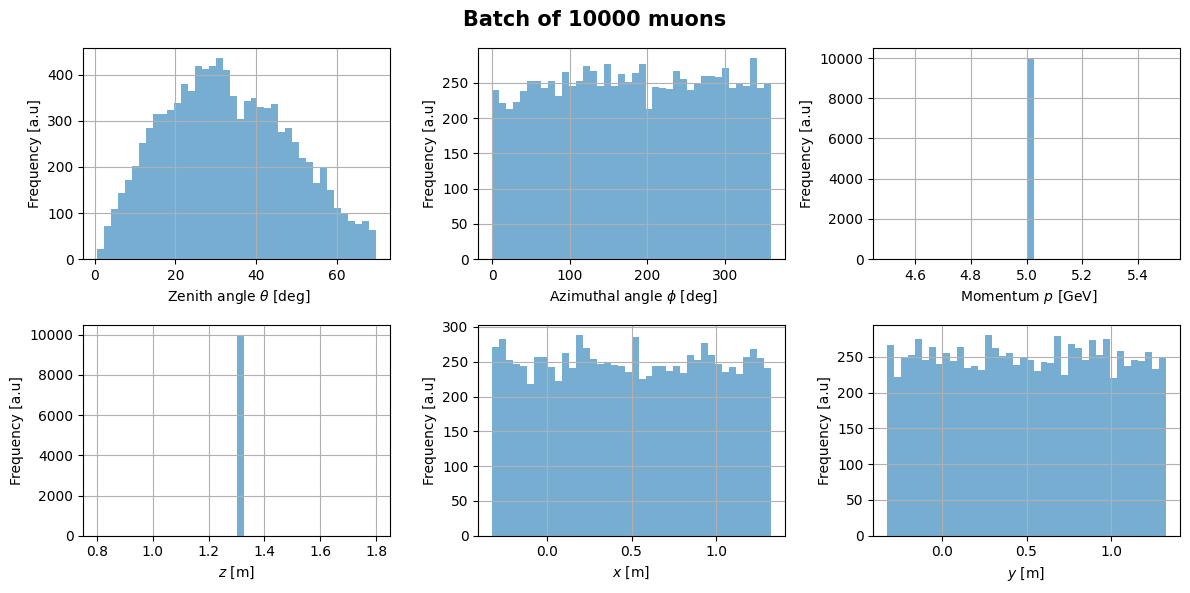

In [33]:
plot_muon_batch(muons)

We can pass muons through the entire volume by simply calling the `forward` method of the `Volume`, which will pass the muon batch though each layer in turn:

In [34]:
volume(muons)

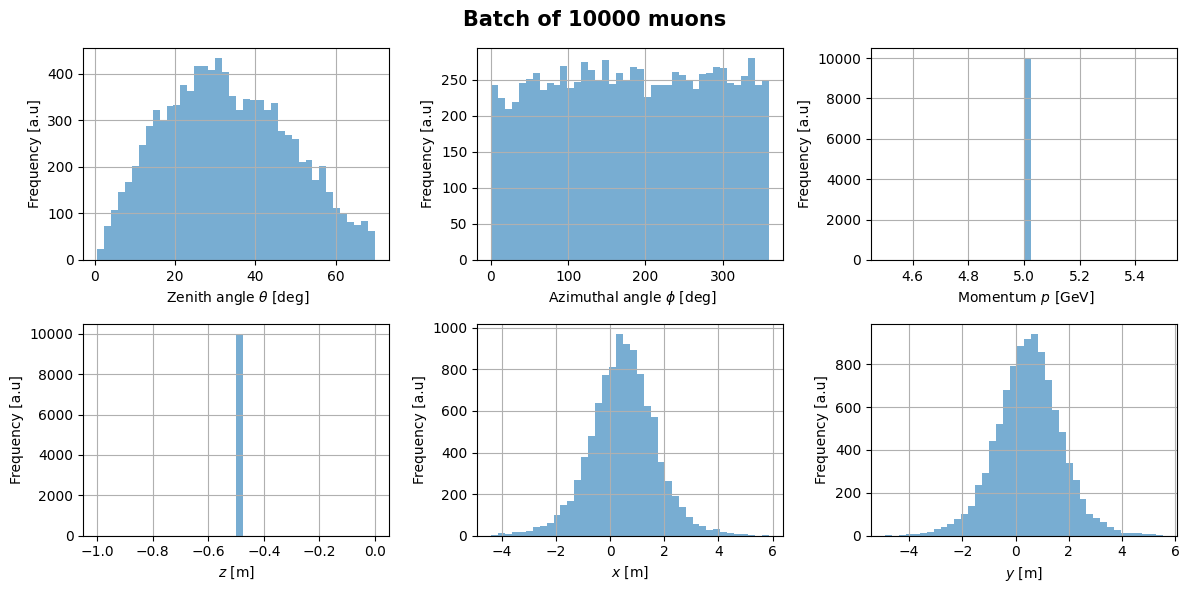

In [35]:
plot_muon_batch(muons)

The `PassiveLayer` described in section **II-A** inherits from `tomopt.volume.layer.Layer`, which in turn inherits from `torch.nn.Module`, and passing a `MuonBatch` through a `Layer` involves calling its `forward` method (or calling the object, since `nn.Module.__call__` points to `forward`).

When a `MuonBatch` is passed through the `PassiveLayer`, it does so in `n` steps of $\delta z$, and at each step undergoes multiple scattering according the material traversed. 

Note that the `forward` method does not return the propagated `MuonBatch`, but instead updates the internal parameters of the `MuonBatch` in-place.

We can also access the hits in the four detector layers:

In [36]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[-0.1210, -0.2364,  1.2000],
           [-0.0710, -0.2475,  1.1500],
           [-0.0273, -0.1954,  1.1000],
           [ 0.1855, -0.1439,  0.9000],
           [ 0.2370, -0.1103,  0.8500],
           [ 0.2859, -0.1074,  0.8000]],
  
          [[ 1.2748,  0.1126,  1.2000],
           [ 1.2422,  0.1200,  1.1500],
           [ 1.3446,  0.1305,  1.1000],
           [ 1.4344,  0.1818,  0.9000],
           [ 1.3690,  0.1930,  0.8500],
           [ 1.4808,  0.2034,  0.8000]],
  
          [[ 0.7485,  0.2853,  1.2000],
           [ 0.7297,  0.2778,  1.1500],
           [ 0.7139,  0.2718,  1.1000],
           [ 0.6473,  0.2466,  0.9000],
           [ 0.6281,  0.2380,  0.8500],
           [ 0.6137,  0.2332,  0.8000]],
  
          ...,
  
          [[ 0.4879,  0.8403,  1.2000],
           [ 0.4819,  0.8639,  1.1500],
           [ 0.4746,  0.8872,  1.1000],
           [ 0.4457,  0.9806,  0.9000],
           [ 0.4389,  1.0064,  0.8500],
           [ 0.4335,  1.0275,

In [37]:
hits['above']['reco_xyz'].shape  # (muons, detector layer, xy)

torch.Size([10000, 6, 3])

## **III - Scattering inference**

Now that we can **construct volumes** and **pass muons through** them, the next step is to **infer** the **composition** of the **passive volume** from the scattering of the muons. 

So far in TomOpt, the only method implemented uses the **Point Of Closest Approach (POCA)**. This involves extrapolating straight lines from hits in the detector panels above and below the passive volume. The difference in angle for these lines is due to the multiple scattering across all of the passive layers, however as a simplification, the entirety of the multiple scattering is assumed to have occurred at the point of closest approach of the two lines; i.e. every muon only provides information for a single point, and that information is biased to underestimate x0.

The `tomopt.inference.scattering.ScatterBatch` class is initialised using the muon batch after propagation and the volume through which it was propagated. For every muon that stays within the volume, it will compute in absolute units:
- `poca_xyz`: The location of the point of closest approach. (muons, x, y, z).
- `dphi`: The difference in $\phi$ of the extrapolated muons trajectories, i.e. the shift in angle due to multiple scattering. (muons, $\delta\phi$).
- `total_scatter`: The difference in $\theta$ of the extrapolated muons trajectories, i.e. the shift in angle due to multiple scattering. (muons, $\delta\theta$).
- `dxy`: The length of the normal vector between the extrapolated muons trajectories, i.e. the shift in xy due to multiple scattering. (muons, $\delta x$, $\delta y$).
- `theta_in` & `theta_out`: The estimated $\theta$ of the incoming & outgoing muons. (muons, $\theta$).
- `*_unc`: The uncertainties associated with the above quantities due to the resolution associated with the hits. These are computed via auto-differentiation and can be quite slow.



The incoming and outgoing muon projection lines are fitted to the recorded hits in the panels by conisdering the uncertainty on the recorded hit.

More details about the muon hit recording can be found in Section 2.4 *Trajectory fitting and point of closest approach* of the [TomOpt paper](https://iopscience.iop.org/article/10.1088/2632-2153/ad52e7).


In [38]:
from tomopt.inference import ScatterBatch

In [39]:
# Create muon batch
muons = MuonBatch(gen(1000), init_z=1.4)

# create volume
volume = Volume(get_layers(hod_layers = [layer_above, layer_below]))

# Propagate muons through the volume
volume(muons)

In [40]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 285 ms, sys: 0 ns, total: 285 ms
Wall time: 104 ms


In [41]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 15.6 s, sys: 5.41 s, total: 21 s
Wall time: 5.52 s


(tensor([[ 0.2280,  1.3927, -0.2696],
         [ 0.7815,  1.7032, -1.3573],
         [ 1.7953,  0.4009, -0.6499],
         ...,
         [ 1.7073,  0.7187, -0.3961],
         [-0.8606,  0.4995, -0.6085],
         [-0.4991, -0.6572, -0.1925]], grad_fn=<AddBackward0>),
 tensor([[ 0.0746,  0.0321,  0.1858],
         [ 0.7751,  2.4212, 10.7155],
         [ 0.5437,  0.4204,  1.9910],
         ...,
         [ 0.1327,  0.1715,  0.3609],
         [ 4.5197,  0.5146,  7.1376],
         [ 0.0907,  0.0765,  0.0658]], grad_fn=<SqrtBackward0>))

We can also plot the hits, tracks and POCA for each muon separatly:

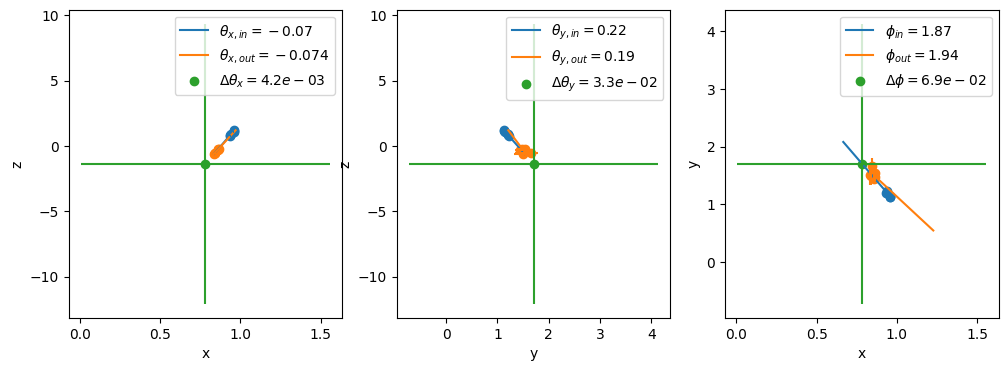

In [42]:
sb.plot_scatter(idx=1)

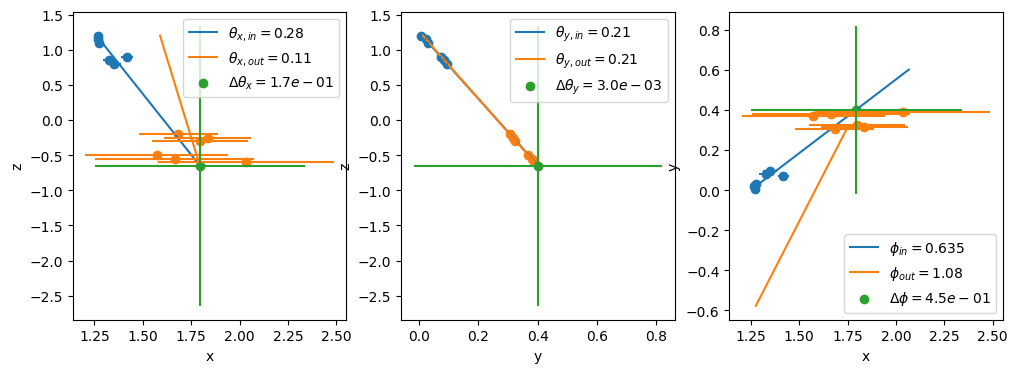

In [43]:
sb.plot_scatter(idx=2)


## **IV - $X_0$ inference**

From the scattering information, the next step is to infer the $X_0$ of the passive volume. 

This is achieved by inverting the scattering equations to put them in terms of $X_0$, however currently only the $\theta$ scattering formula has been inverted. 

$$
X_0 = (\frac{13.6 \text{MeV}}{p})^2 \frac{\delta z}{cos(\bar{\theta}^{\text{rms}})} \frac{2}{\theta_{\text{tot}}^{\text{rms} 2}}
$$

Where $\theta_{\text{tot}}^{\text{rms}}$ is the root mea square of the measured scattering angles, and $\bar{\theta}^{\text{rms}} = \theta^{\text{rms}}_{\text{in}} + \theta^{\text{rms}}_{\text{out}} / 2$, with $\theta^{\text{rms}}_{\text{in, out}}$ the incoming / outgoing zenith angle.

*N.B.* the scattering formulas include random terms whose means of squares are one, however this relies on a sufficient number of muons **per voxel** in order to provide an accurate inference of x0. This, combined with the biased computation of the total amount of scattering and the uncertainty due to resolution on scattering properties, means that x0 inference can be expected to be both inaccurate and imprecise.

To account for the fact that the inferred scatter location is uncertain and predictions of each muon carry different uncertainties, the x0 prediction is computed per voxel using a weighted RMS of the scattering variables. The weights per voxel account for the efficiency of the detectors the muon passed through, the uncertainty in the muons' scattering parameters, and the probability of the scattering occurring in the given voxel according to the inferred scatter location and its uncertainty.

`tomopt.inference.volume.PanelX0Inferrer` is used to compute predictions of the x0 composition of the passive volume from the `ScatterBatch` results.

More details about the cosmic muon generation can be found in Section 2.5 *Volume inference* of the [TomOpt paper](https://iopscience.iop.org/article/10.1088/2632-2153/ad52e7).

In [44]:
from tomopt.inference import PanelX0Inferrer
import numpy as np

In [45]:
x0_inferrer = PanelX0Inferrer(volume=volume)

`x0_from_scatters` computes the x0 predicted from the scatter parameters:

In [46]:
%%time
pred = x0_inferrer.x0_from_scatters(deltaz=volume.passive_size,
                                    total_scatter=sb.total_scatter.square().mean().sqrt()/np.sqrt(2),
                                    theta_in=sb.theta_in.square().mean().sqrt(),
                                    theta_out=sb.theta_out.square().mean().sqrt(),
                                    mom=sb.mu.mom[:,None].square().mean().sqrt())
pred

CPU times: user 1.29 ms, sys: 339 µs, total: 1.63 ms
Wall time: 1.18 ms


tensor(3.9777e-06, grad_fn=<DivBackward0>)

From the above function, we see that we convert the whole population of muons to a single prediction. Instead, we need to compute different scatter variables using a weighted RMS based on the muon PoCA locations. 

Since some **muons carry** different **uncertainties** and **efficiencies**, we adjust the weights to also account for these. 

The weight for muon $i$ and voxel $j$ for variable $v$ is:
$$
w_{v,i,j} = \frac{\epsilon_i\times p_{i,j}}{\left(2v\alpha_{v_{0,i}}\right)^2},
$$

where $\epsilon$ is the **total efficiency** of the **hits** associated with muon $i$, $\alpha_{v_{i}}$ is the **uncertainty** associated with variable $v$ of muon $i$, and $p_{i,j}$ is the integral in x,y,z over voxel $j$ of a mulitivariate Gaussian (uncorrelated) centred at the scatter location of muon $i$ and widths equal to the uncertainty of the scatter location in x,y,z.

`PanelX0Inferrer` is set up to handle multiple batches of muon scatters. Variables are then computed by combining these batches together. Variables are computed when required (lazy evaluation) and then cached for later use. Adding a new batch will clear the cache.

In [47]:
x0_inferrer.add_scatters(sb)

The muon probabilities per voxel are a rank-4 tensor (mu, z, x, y)

In [48]:
x0_inferrer.muon_probs_per_voxel_zxy.shape

torch.Size([586, 5, 10, 10])

The efficiencies and variables are rank-1,2 tensors 

In [49]:
x0_inferrer.muon_efficiency.shape, x0_inferrer.muon_total_scatter.shape

(torch.Size([586]), torch.Size([586, 1]))

The `_get_voxel_zxy_x0_preds` method will expand the efficiencies and variables to match the shape of the `muon_probs_per_voxel_zxy`. The weighted RMS then aggregates over the muons, resulting in a rank-3 tensor (z,x,y). These weighted variables can then be fed to `x0_from_scatters`, to compute an X0 per voxel.

In [50]:
pred = x0_inferrer._get_voxel_zxy_x0_preds()

In [51]:
pred

tensor([[[0.0179, 0.0202, 0.0202, 0.0021, 0.0081, 0.0051, 0.0048, 0.0086,
          0.0083, 0.0099],
         [0.0223, 0.0183, 0.0103, 0.0043, 0.0078, 0.0049, 0.0042, 0.0048,
          0.0112, 0.0132],
         [0.0120, 0.0111, 0.0058, 0.0033, 0.0071, 0.0066, 0.0039, 0.0039,
          0.0076, 0.0130],
         [0.0156, 0.0159, 0.0057, 0.0031, 0.0032, 0.0029, 0.0043, 0.0095,
          0.0114, 0.0152],
         [0.0324, 0.0144, 0.0138, 0.0069, 0.0055, 0.0102, 0.0138, 0.0246,
          0.0246, 0.0217],
         [0.0290, 0.0122, 0.0060, 0.0055, 0.0049, 0.0037, 0.0054, 0.0158,
          0.0234, 0.0231],
         [0.0130, 0.0085, 0.0046, 0.0056, 0.0065, 0.0028, 0.0054, 0.0047,
          0.0086, 0.0092],
         [0.0074, 0.0071, 0.0054, 0.0082, 0.0088, 0.0036, 0.0013, 0.0023,
          0.0053, 0.0068],
         [0.0098, 0.0052, 0.0024, 0.0087, 0.0088, 0.0085, 0.0030, 0.0036,
          0.0057, 0.0117],
         [0.0195, 0.0085, 0.0057, 0.0076, 0.0051, 0.0019, 0.0042, 0.0058,
          0.0071,

In general, we use the `get_prediction` method, which returns the per voxel predictions:

In [52]:
pred = x0_inferrer.get_prediction()

In [53]:
pred.shape

torch.Size([5, 10, 10])

## **V - Loss function**

A range of loss classes are implemented in TomOpt: `tomopt.optimisation.loss.loss`. 


For this example we will are trying to predict the X0 of each voxel, so we will use the `VoxelX0Loss`. 

This consists of two components: 

 - The precision component, based on the square error, averaged over the voxels $\left< \left(x_{0,\mathrm{pred}}-x_{0,\mathrm{true}}\right)^2\right>$
 -  The budget cost of the whole detector timesed by a scaling coefficient. The budget cost is a function which is close to zero when the cost is below budget, and increases linearly when the cost is above budget. 
 
 We initialise the loss by specifying the target budget (can set to `None` for no budget), the cost coefficient used to math the cost and error loss components (this can be set automatically by setting it to `None` and optionally using `tomopt.optimisation.callbacks.loss_callbacks.CostCoefWarmup`). 
 
 For this tutorial, we'll set the target budget to `None` to swicth off the cost of the detector.

In [54]:
from tomopt.optimisation import VoxelX0Loss

In [55]:
loss_func = VoxelX0Loss(target_budget=None)

In [56]:
loss_val = loss_func(pred=pred, volume=volume)
loss_val

Automatically setting cost coefficient to 0.0001001834316411987


tensor([0.0001], grad_fn=<AddBackward0>)

Let's backprop the loss and check that the detector parameters accumulate gradients:

In [57]:
volume.get_detectors()[0].hodoscopes[0].panels[0].xy.grad, volume.get_detectors()[0].hodoscopes[0].panels[0].z.grad

(None, None)

In [58]:
loss_val.backward()

In [59]:
volume.get_detectors()[0].hodoscopes[0].panels[0].xy.grad, volume.get_detectors()[0].hodoscopes[0].panels[0].z.grad

(tensor([-1.6671e-05, -9.4930e-05]), tensor([-8.2375e-05]))

## **VI - Optimiser**

TomOpt uses the optimisers built into PyTorch, however due to the difference in scales for the parameters, we instead use three separate optimisers:

In [60]:
from torch import optim

In [61]:
xy_opt = optim.SGD((p.xy for l in volume.get_detectors() for h in l.hodoscopes for p in h.panels), lr=1e0)
z_opt = optim.SGD((p.z for l in volume.get_detectors() for h in l.hodoscopes for p in h.panels ), lr=1e0)

In [62]:
xy_opt.step()
z_opt.step()

In [63]:
volume.get_detectors()[0].hodoscopes[0].panels[0].xy.grad, volume.get_detectors()[0].hodoscopes[0].panels[0].z.grad

(tensor([-1.6671e-05, -9.4930e-05]), tensor([-8.2375e-05]))